# Task 3: Customer Segmentation Using differnt Clustering algorithms

In [51]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import davies_bouldin_score # For Calculating DB Index
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
#Loading the relevant datasets as per the task
customer_data = pd.read_csv('C:\\Users\\palla\\Desktop\\Zeotap_intern\\Datasets\\Customers.csv')
Transactions_data = pd.read_csv('C:\\Users\\palla\\Desktop\\Zeotap_intern\\Datasets\\Transactions.csv')

In [53]:
# Preprocessing the data before implementing clistreing algorithms
# Merging profile and transaction data 
merged_data = pd.merge(customer_data, Transactions_data, on="CustomerID", how="inner") #Using inner join to merge the data because we need the data which is present in both the datasets
merged_data.shape
merged_data.head()

,CustomerID,CustomerName,Region,SignupDate,TransactionID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,C0001,Lawrence Carroll,South America,2022-07-10,T00015,P054,2024-01-19 03:12:55,2,114.60,57.30
1,C0001,Lawrence Carroll,South America,2022-07-10,T00932,P022,2024-09-17 09:01:18,3,412.62,137.54
2,C0001,Lawrence Carroll,South America,2022-07-10,T00085,P096,2024-04-08 00:01:00,2,614.94,307.47
3,C0001,Lawrence Carroll,South America,2022-07-10,T00445,P083,2024-05-07 03:11:44,2,911.44,455.72
4,C0001,Lawrence Carroll,South America,2022-07-10,T00436,P029,2024-11-02 17:04:16,3,1300.92,433.64


In [54]:
# Extracting features to perform clustering
features = merged_data[['Quantity','TotalValue', 'Price']]

In [55]:
# Standardizing the features for clustering
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

Best DB Index for KMeans: 0.6885034703859554
Best Parameters for KMeans: {'n_clusters': 10}


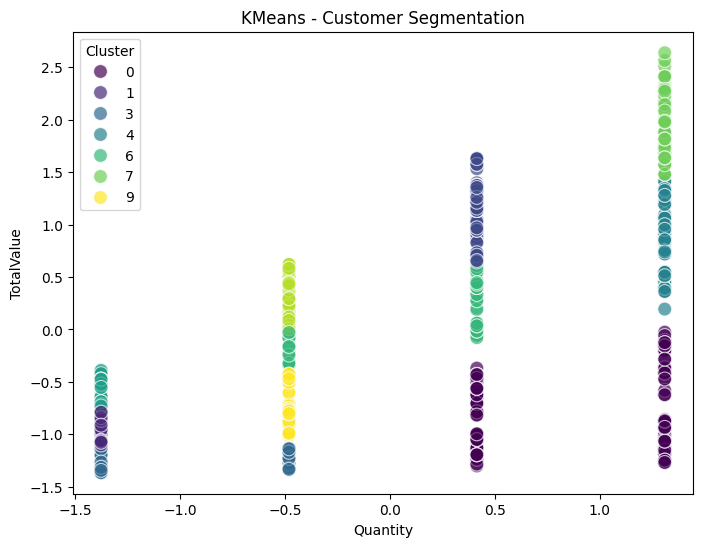

Best DB Index for AgglomerativeClustering: 0.6421406420331665
Best Parameters for AgglomerativeClustering: {'n_clusters': 8, 'linkage': 'average'}


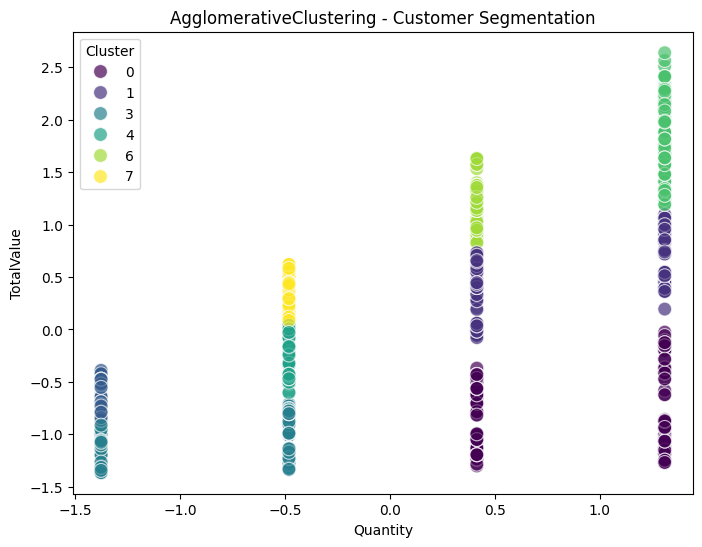

Best DB Index for GaussianMixture: 0.769049964790562
Best Parameters for GaussianMixture: {'n_components': 4}


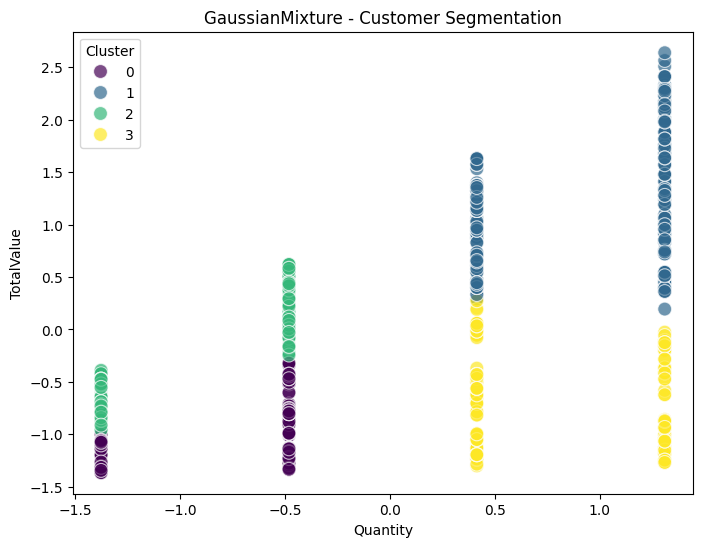

Best DB Index for DBSCAN: 0.5153624379105786
Best Parameters for DBSCAN: {'eps': 0.2, 'min_samples': 3}


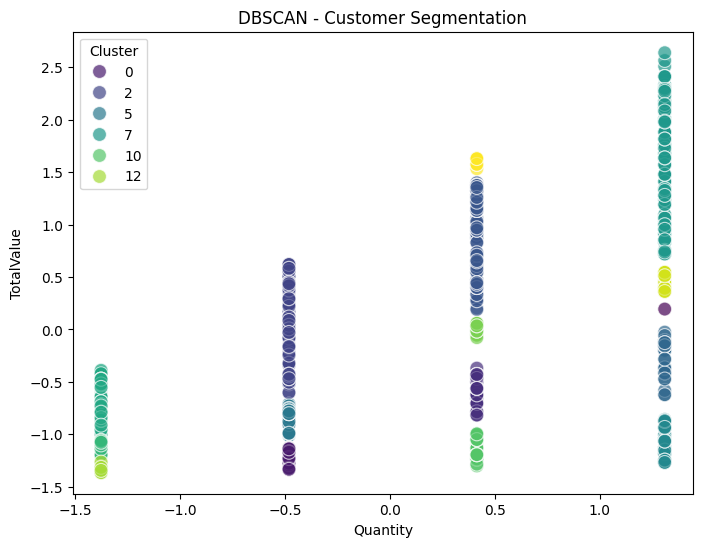

Best DB Index for MeanShift: 0.3852021743762533
Best Parameters for MeanShift: {'bandwidth': 0.1}


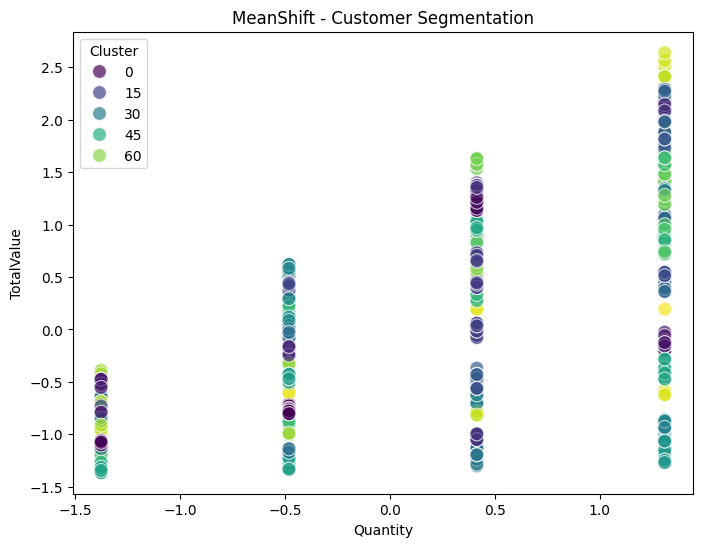

In [56]:
# Defing Function to evaluate clustering models and plot results
def evaluate_and_plot(model, param_grid, features_scaled, model_name):
    """
    This function evaluates clustering models manually by iterating over hyperparameters, 
    calculates the Davies-Bouldin Index (DBI) for clustering quality, 
    and plots the clustered data.

    Arguments:
    model: Clustering model to evaluate
    param_grid: Hyperparameter grid for tuning
    features_scaled: Preprocessed data
    model_name: Name of the model for printing purposes
    """
    best_db_index = float('inf')  # Initializing to infinity for comparison
    best_params = None
    best_labels = None

    #iterating over hyperparameter combinations for each model to find best model parameters
    for params in param_grid:
        # Initializing model with the current parameters
        if model_name == "KMeans":
            current_model = model(n_clusters=params['n_clusters'])
        elif model_name == "AgglomerativeClustering":
            current_model = model(n_clusters=params['n_clusters'], linkage=params['linkage'])
        elif model_name == "GaussianMixture":
            current_model = model(n_components=params['n_components'])
        elif model_name == "DBSCAN":
            current_model = model(eps=params['eps'], min_samples=params['min_samples'])
        elif model_name == "MeanShift":
            current_model = model(bandwidth=params['bandwidth'])
        
        # Fitting the model and predict labels
        if hasattr(current_model, 'fit_predict'):
            labels = current_model.fit_predict(features_scaled)
        else:
            current_model.fit(features_scaled)
            labels = current_model.labels_
        
        # Calculating Davies-Bouldin Index
        db_index = davies_bouldin_score(features_scaled, labels)
        
        # Tracking the best DBI and corresponding parameters
        if db_index < best_db_index:
            best_db_index = db_index
            best_params = params
            best_labels = labels

    # Output the best DB Index and parameters
    print(f"Best DB Index for {model_name}: {best_db_index}")
    print(f"Best Parameters for {model_name}: {best_params}")
    
    # Plotting: Visualize the clustering results using the best labels
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=features_scaled[:, 0], y=features_scaled[:, 1], hue=best_labels, palette="viridis", s=100, alpha=0.7)
    plt.title(f"{model_name} - Customer Segmentation")
    plt.xlabel("Quantity")
    plt.ylabel("TotalValue")
    plt.legend(title="Cluster")
    plt.show()

# Defining parameter grids for each model 

param_grids = {
    # KMeans: Varying number of clusters between 2 and 10
    "KMeans": [{'n_clusters': i} for i in range(2, 11)],  
    
    # AgglomerativeClustering: Varying number of clusters and linkage types
    "AgglomerativeClustering": [{'n_clusters': i, 'linkage': linkage} 
                                for i in range(2, 11) 
                                for linkage in ['ward', 'complete', 'average', 'single']],
    
    # GaussianMixture: Varying number of components (clusters)
    "GaussianMixture": [{'n_components': i} for i in range(2, 11)],
    
    # DBSCAN: Varying eps and min_samples for density-based clustering
    "DBSCAN": [{'eps': eps, 'min_samples': min_samples} 
               for eps in [0.1, 0.2, 0.3, 0.4, 0.5] 
               for min_samples in [3, 5, 7, 10]],
    
    # MeanShift: Varying bandwidth values
    "MeanShift": [{'bandwidth': bw} for bw in [0.1, 0.2, 0.3, 0.4, 0.5]]
}

# List of clustering algorithms to evaluate
models = [
    (KMeans, "KMeans"),
    (AgglomerativeClustering, "AgglomerativeClustering"),
    (GaussianMixture, "GaussianMixture"),
    (DBSCAN, "DBSCAN"),
    (MeanShift, "MeanShift")
]

# Evaluate and visualize each clustering algorithm
for model, model_name in models:
    evaluate_and_plot(model, param_grids[model_name], features_scaled, model_name)


+ From the above analysis Guassian Mixture and DBSCAN performs better for Customer Segementation 